# Basic Geomedian calculation example 

**Background:** The geometric median ([geomedian](http://ieeexplore.ieee.org/document/8004469/)) is a high dimensional compositing method that summarises the central tendancy of a stack of satellite imagery while preserving relationships between spectral bands. This notebook demonstrates to how generate a geomedian composite from a stack of Landsat data extracted using the OpenDataCube/DigitalEarthAustralia API.

**Requirements**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date**: August 2018

**Authors**: Robbi Bishop-Taylor

## Import modules

In [1]:
import datacube
from datacube_stats.statistics import GeoMedian
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.helpers import write_geotiff

# Create datacube instance
dc = datacube.Datacube(app='Basic geomedian example')

## Set up datacube query for data extraction

In [30]:
# Set up analysis data query that defines time and spatial extent. This example uses coordinates 
# in the native coordinate system of the DigitalEarthAustralia data (Australian Albers, EPSG:3577)
query = {'x': (-1822487, -1785376),
         'y': (-2944344, -2938344),
         'time': ('2017-01-22', '2017-03-01'),
         'crs': 'EPSG:3577'}

# If below code runs excessively slow, you may need to reduce the resolution of the data by adding
# the following to the above query (where resolution is your new cell size vs (-25, 25):
#        'output_crs': 'EPSG:3577',
#        'resolution': (-100, 100)


## Load Landsat data

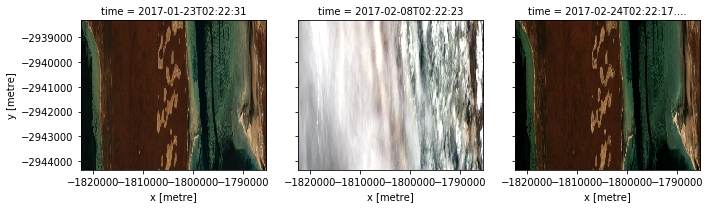

In [31]:
# Return observations for the matching query 
landsat_ds = dc.load(product = 'ls8_nbart_albers', 
                     group_by = 'solar_day', 
                     **query)

# Plot as RGB image
landsat_ds[['red', 'green', 'blue']].to_array().plot.imshow(col='time', col_wrap=3, robust=True)


## Load Pixel Quality (PQ) data and create PQ mask

In [32]:
# Load PQ data for same query used to load Landsat data
pq_ds = dc.load(product = 'ls8_pq_albers',
                group_by = 'solar_day',
                fuse_func=ga_pq_fuser, 
                **query)

# Use PQ to create mask that is True for pixels that are not affected by clouds, cloud shadow or saturation
good_quality = masking.make_mask(pq_ds.pixelquality,
                                 cloud_acca='no_cloud',
                                 cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)


## Mask out invalid and poor pixel quality (e.g. clouds, cloud shadow, saturated pixels)

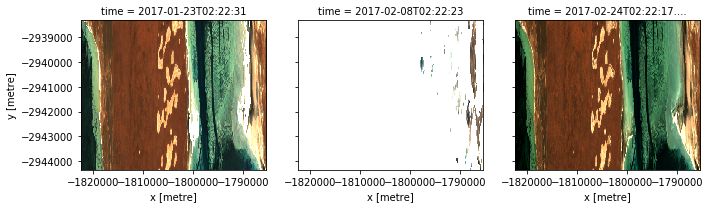

In [33]:
# Remove -999 nodata values prior to analysing or plotting Landsat imagery by setting all nodata values to `NaN` 
landsat_ds = masking.mask_invalid_data(landsat_ds)

# Apply the mask to preserve only the good data
landsat_ds = landsat_ds.where(good_quality)

# Plot masked layer as RGB image
landsat_ds[['red', 'green', 'blue']].to_array().plot.imshow(col='time', col_wrap=3, robust=True)

## Compute geomedian from time series

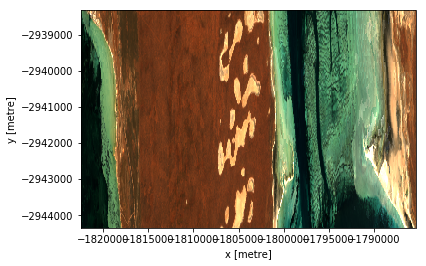

In [35]:
# Compute geomedian composite using all timesteps
geomedian_ds = GeoMedian().compute(landsat_ds)
    
# Plot geomedian layer as RGB image
geomedian_ds[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

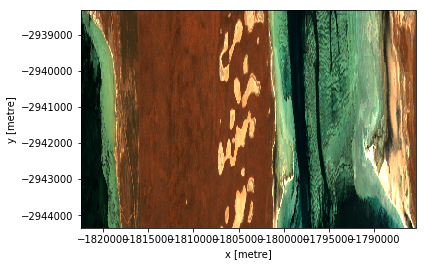

In [37]:
# For a simple median (faster but does not preserve band relationships):
median_ds = landsat_ds.median(dim='time')
median_ds[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

## Export as GeoTiff

In [36]:
# Export to file
write_geotiff(filename='geomedian.tif', dataset=geomedian_ds)